In [1]:
using Distributions
using HypothesisTests
using Optim
using QuadGK
using Random
using Roots
using StatsFuns
using StatsPlots
default(fmt=:png, legendfontsize=10)

pgfplotsx()
PGFPlotsX.CUSTOM_PREAMBLE=[raw"\usepackage{luatexja}"]
@eval Plots pgfx_sanitize_string(s::AbstractString) = s
gr()

distname(dist) = replace(string(dist), r"{[^}]*}"=>"", r".="=>"")

function distname(dist::Binomial)
    n, p = params(dist)
    p = round(p; sigdigits=3)
    "Bin($n, $p)"
end

safemul(x, y) = x == 0 ? zero(x/y) : isinf(x) ? oftype(x, Inf) : x*y
safediv(x, y) = x == 0 ? zero(x/y) : isinf(y) ? zero(y) : x/y
x ⪅ y = x < y || x ≈ y
_ecdf(A, x) = count(≤(x), A) / length(A)

function pvalue_chisq(a, b, c, d; yates=false)
    N = a+b+c+d
    chisqstat = safediv(N*max(0, abs(a*d - b*c) - (N/2)yates)^2, (a+b)*(c+d)*(a+c)*(b+d))
    ccdf(Chisq(1), chisqstat)
end

pvalue_chisq (generic function with 1 method)

In [2]:
oddsratiohat(a, b, c, d) = safediv(a*d, b*c)

# score method for OR

function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? oftype(ω, -min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0, h=0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    (a+b+c+d-h)/(a+b+c+d) * safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0, h=0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction, h)
end

function pvalue_or_score(a, b, c, d; ω=1, correction=0.0, h=0)
    χ² = chisqstat_or(a, b, c, d; ω, correction, h)
    ccdf(Chisq(1), χ²)
end

function confint_or_score(a, b, c, d; α=0.05, correction=0.0, h=0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = pvalue_or_score(a, b, c, d; ω=exp(logω), correction, h) - α
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        #ORhat = oddsratiohat(a, b, c, d)
        #ω_L, ω_U = ORhat/2, 2ORhat
        #[exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
        logORhat = log(oddsratiohat(a, b, c, d))
        logL = find_zero(f, (logORhat-100, logORhat))
        logU = find_zero(f, (logORhat, logORhat+100))
        [exp(logL), exp(logU)]
    end
end

confint_or_score (generic function with 1 method)

In [3]:
# Fisher's method (central) for OR

function pvalue_or_fisher_central(a, b, c, d; ω=1, correction=0.0)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    min(1, 2(cdf(fnch, a) - correction*pdf(fnch, a)), 2(ccdf(fnch, a-1) - correction*pdf(fnch, a)))
end

function confint_or_fisher_central(a, b, c, d; α = 0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(ω) = pvalue_or_fisher_central(a, b, c, d; ω, correction) - α
    if a == 0 || d == 0
        [0.0, find_zero(f, 1.0)]
    elseif b == 0 || c == 0
        [find_zero(f, 1.0), Inf]
    else
        ω_L, ω_U = confint_or_score(a, b, c, d; α)
        ω_L, ω_U = ω_L/(ω_U/ω_L), ω_U*(ω_U/ω_L)
        find_zeros(f, ω_L, ω_U)
    end
end

confint_or_fisher_central (generic function with 1 method)

In [4]:
# Fisher's method (minlike) for OR

function oddsratiohat_fisher(a, b, c, d)
    f(x) = -logpdf(FisherNoncentralHypergeometric(a+b, c+d, a+c, x[1]), a)
    ω₀ = oddsratiohat(a, b, c, d)
    o = optimize(f, [ω₀])
    o.minimizer[1]
end

_pdf_le(x, (dist, y)) =  pdf(dist, x) ⪅ y

function _search_boundary(f, x0, Δx, param)
    x = x0
    if f(x, param)
        while f(x - Δx, param) x -= Δx end
    else
        x += Δx
        while !f(x, param) x += Δx end
    end
    x
end

function pvalue_minlike(dist::DiscreteUnivariateDistribution, x; correction=0.0)
    Px = pdf(dist, x)
    Px == 0 && return Px
    Px == 1 && return Px
    m = mode(dist)
    if pdf(dist, m) ≈ Px
        one(Px) - 2correction * (pdf(dist, m-1) ≈ Px || pdf(dist, m+1) ≈ Px) * Px
    elseif x < m
        y = _search_boundary(_pdf_le, 2m - x, 1, (dist, Px))
        cdf(dist, x) + ccdf(dist, y-1) - correction * (1 + (pdf(dist, y) ≈ Px)) * Px
    else # x > m
        y = _search_boundary(_pdf_le, 2m - x, -1, (dist, Px))
        cdf(dist, y) + ccdf(dist, x-1) - correction * (1 + (pdf(dist, y) ≈ Px)) * Px
    end
end

function pvalue_or_fisher_minlike(a, b, c, d; ω=1, correction=0.0)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    pvalue_minlike(fnch, a; correction)
end

function find_pos(f, x)
    while f(x) ≤ 0
        x *= 2
    end
    x
end

function confint_or_fisher_minlike(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_fisher_minlike(a, b, c, d; ω=exp(logω))) - logit(α)
    if a == 0 || d == 0
        [0.0, exp(find_zero(f, (find_pos(f, -1.0), 0.0)))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, (0.0, find_pos(f, 1.0)))), Inf]
    else
        ω_L, ω_U = confint_or_score(a, b, c, d; α)
        ω_L, ω_U = ω_L/(ω_U/ω_L), ω_U*(ω_U/ω_L)
        ps = exp.(find_zeros(f, log(ω_L), log(ω_U)))
        # 次の行は稀に区間にならない場合への対策
        isempty(ps) ? [0, Inf] : [first(ps), last(ps)]
    end
end

confint_or_fisher_minlike (generic function with 1 method)

In [5]:
function pvals(randabcd; niters=10^5, yates=0.0)
    pval_score = zeros(niters)
    pval_score_adj = zeros(niters)
    pval_central_midp = zeros(niters)
    pval_minlike_midp = zeros(niters)
    Threads.@threads :static for i in 1:niters
        a, b, c, d = randabcd()
        pval_score[i] = pvalue_or_score(a, b, c, d)
        pval_score_adj[i] = pvalue_or_score(a, b, c, d; h=1)
        pval_central_midp[i] = pvalue_or_fisher_central(a, b, c, d; correction=0.5)
        pval_minlike_midp[i] = pvalue_or_fisher_minlike(a, b, c, d; correction=0.5)
    end
    (; pval_score, pval_score_adj, pval_central_midp, pval_minlike_midp)
end

function make_randabcd(bin1::Binomial, bin2::Binomial)
    function randabcd_2binomials()
        a, c = rand(bin1), rand(bin2)
        b, d = ntrials(bin1)-a, ntrials(bin2)-c
        a, b, c, d
    end
    randabcd_2binomials
end

function plot_pvals(; bin1=Binomial(12, 0.25), bin2=Binomial(16, 0.25), niters=10^6, yates=1/12)
    m, p = params(bin1)
    n, q = params(bin2)
    ytick = p == q ? (0:0.01:1) : (0:0.05:1)
    legend = p == q ? true : (:bottomright)
    yguide = "probability of P-value ≤ α"
    yguide *= p == q ? "  (α-error rate)" : "  (power)"
    
    println("true expectation value: ")
    Base.print_array(stdout, round.([m*p m*(1-p); n*q n*(1-q)]; sigdigits=3))
    println("\n")
    
    randabcd_2binomials = make_randabcd(bin1, bin2)
    (; pval_score, pval_score_adj, pval_central_midp, pval_minlike_midp) =
        pvals(randabcd_2binomials; niters, yates)
    
    print("probability of P-value ≤ 5%")
    println(p == q ? "  (α-error rate)" : "  (power)")
    println("  score:          ", round(100_ecdf(pval_score, 0.05); digits=1), "%")
    #println("  score adjusted: ", round(100_ecdf(pval_score_adj, 0.05); digits=1), "%")
    println("  minlike mid-p:  ", round(100_ecdf(pval_minlike_midp, 0.05); digits=1), "%")
    println("  central mid-p:  ", round(100_ecdf(pval_central_midp, 0.05); digits=1), "%")
    println()
    
    plot(α -> _ecdf(pval_score, α), 0, 0.1; label="score")
    #plot!(α -> _ecdf(pval_score_adj, α), 0, 0.1; label="score adjusted", ls=:dashdot)
    plot!(α -> _ecdf(pval_minlike_midp, α), 0, 0.1; label="minlike mid-p", ls=:dash)
    plot!(α -> _ecdf(pval_central_midp, α), 0, 0.1; label="central mid-p", ls=:dot)
    p == q && plot!(identity; label="", ls=:dot, c=:black, alpha=0.5)
    plot!(; legend)
    plot!(; xtick=0:0.01:1, ytick, xrotation=90)
    plot!(; xguide="α", yguide)
    title!("model: $(distname(bin1))×$(distname(bin2))", titlefontsize=12)
    plot!(size=(400, 400))
end

plot_pvals (generic function with 1 method)

true expectation value: 
 1.0  9.0
 1.0  9.0

probability of P-value ≤ 5%  (α-error rate)
  score:          0.9%
  minlike mid-p:  0.9%
  central mid-p:  0.9%



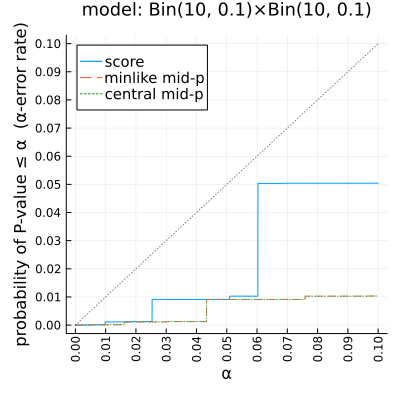

true expectation value: 
 2.0  8.0
 2.0  8.0

probability of P-value ≤ 5%  (α-error rate)
  score:          3.0%
  minlike mid-p:  3.0%
  central mid-p:  3.0%



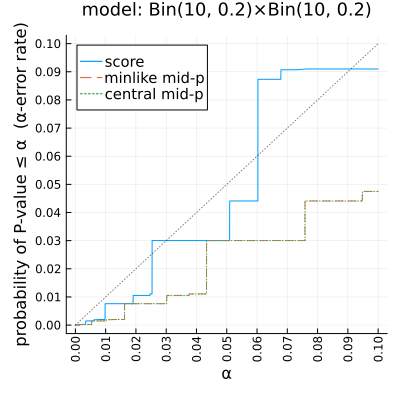

true expectation value: 
 3.0  7.0
 3.0  7.0

probability of P-value ≤ 5%  (α-error rate)
  score:          3.7%
  minlike mid-p:  3.7%
  central mid-p:  3.7%



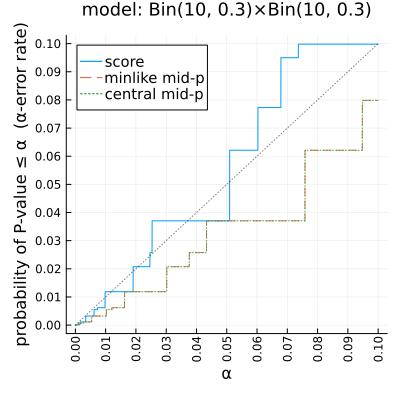

true expectation value: 
 4.0  6.0
 4.0  6.0

probability of P-value ≤ 5%  (α-error rate)
  score:          4.1%
  minlike mid-p:  4.1%
  central mid-p:  4.1%



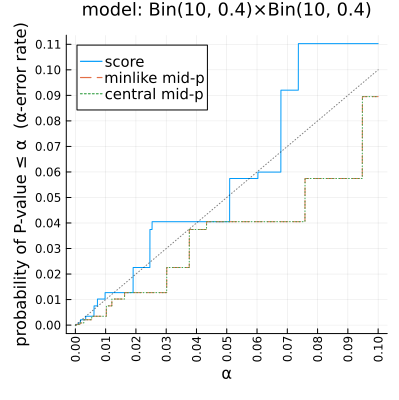

true expectation value: 
 5.0  5.0
 5.0  5.0

probability of P-value ≤ 5%  (α-error rate)
  score:          4.2%
  minlike mid-p:  4.2%
  central mid-p:  4.2%



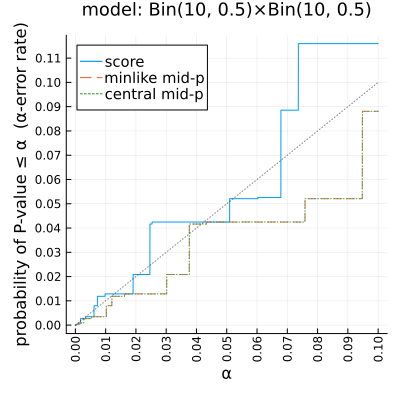

In [6]:
m, n = 10, 10
for q in 0.1:0.1:0.5
    plot_pvals(; bin1=Binomial(m, q), bin2=Binomial(n, q), niters=10^6) |> display
end

true expectation value: 
 0.8   7.2
 1.2  10.8

probability of P-value ≤ 5%  (α-error rate)
  score:          1.5%
  minlike mid-p:  1.3%
  central mid-p:  1.1%



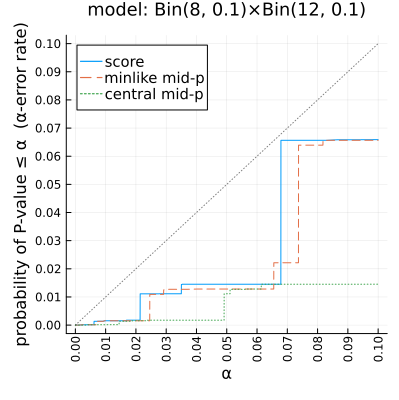

true expectation value: 
 1.6  6.4
 2.4  9.6

probability of P-value ≤ 5%  (α-error rate)
  score:          4.2%
  minlike mid-p:  3.3%
  central mid-p:  2.0%



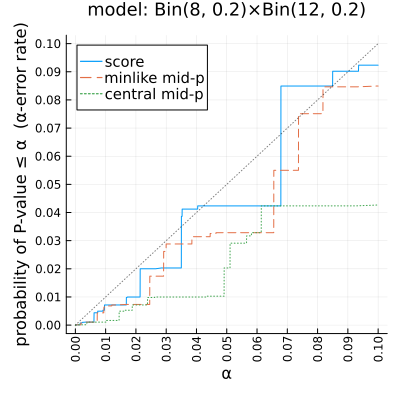

true expectation value: 
 2.4  5.6
 3.6  8.4

probability of P-value ≤ 5%  (α-error rate)
  score:          5.7%
  minlike mid-p:  4.8%
  central mid-p:  2.4%



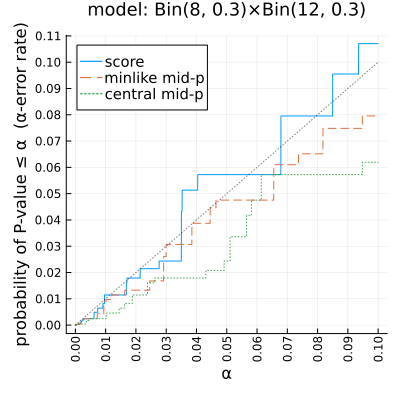

true expectation value: 
 3.2  4.8
 4.8  7.2

probability of P-value ≤ 5%  (α-error rate)
  score:          5.8%
  minlike mid-p:  5.4%
  central mid-p:  3.1%



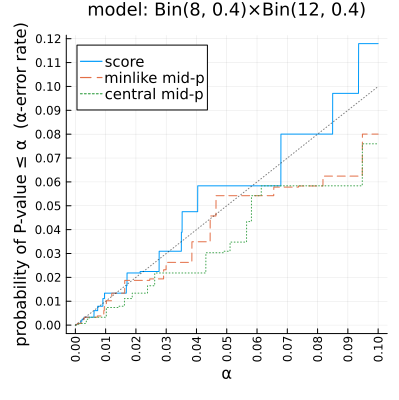

true expectation value: 
 4.0  4.0
 6.0  6.0

probability of P-value ≤ 5%  (α-error rate)
  score:          5.6%
  minlike mid-p:  5.5%
  central mid-p:  3.4%



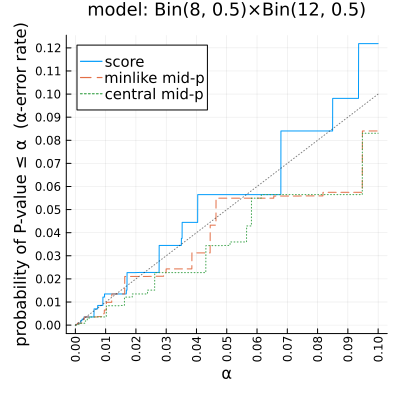

In [7]:
m, n = 8, 12
for q in 0.1:0.1:0.5
    plot_pvals(; bin1=Binomial(m, q), bin2=Binomial(n, q), niters=10^6) |> display
end

true expectation value: 
 0.8   7.2
 1.6  14.4

probability of P-value ≤ 5%  (α-error rate)
  score:          3.9%
  minlike mid-p:  2.1%
  central mid-p:  0.9%



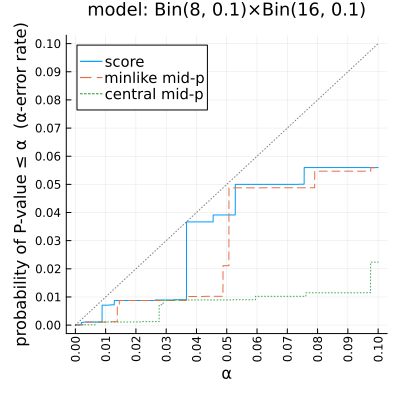

true expectation value: 
 1.6   6.4
 3.2  12.8

probability of P-value ≤ 5%  (α-error rate)
  score:          5.0%
  minlike mid-p:  4.8%
  central mid-p:  2.0%



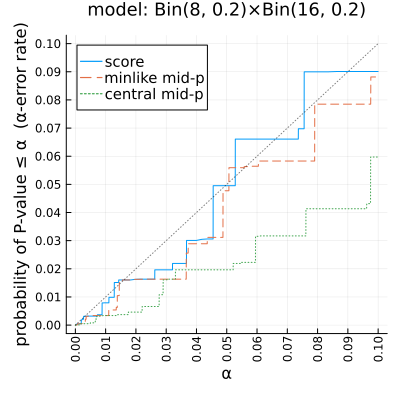

true expectation value: 
 2.4   5.6
 4.8  11.2

probability of P-value ≤ 5%  (α-error rate)
  score:          6.0%
  minlike mid-p:  4.8%
  central mid-p:  2.6%



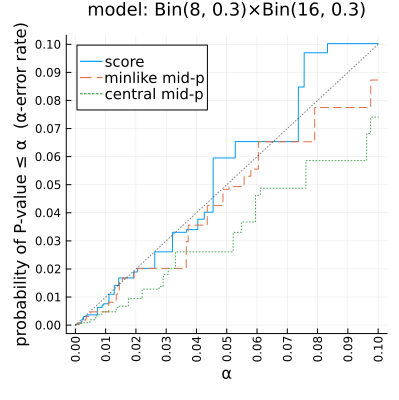

true expectation value: 
 3.2  4.8
 6.4  9.6

probability of P-value ≤ 5%  (α-error rate)
  score:          6.1%
  minlike mid-p:  3.9%
  central mid-p:  2.9%



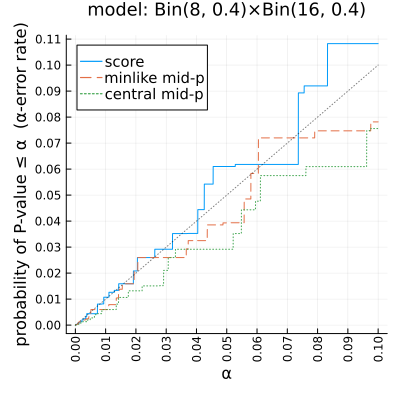

true expectation value: 
 4.0  4.0
 8.0  8.0

probability of P-value ≤ 5%  (α-error rate)
  score:          6.1%
  minlike mid-p:  3.4%
  central mid-p:  3.0%



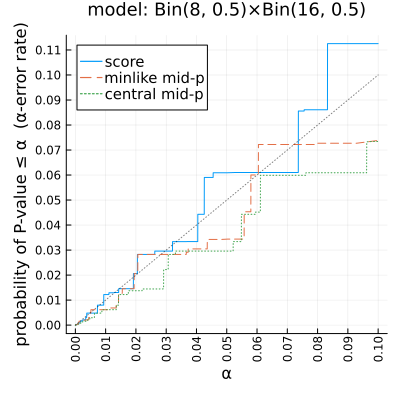

In [8]:
m, n = 8, 16
for q in 0.1:0.1:0.5
    plot_pvals(; bin1=Binomial(m, q), bin2=Binomial(n, q), niters=10^6) |> display
end

true expectation value: 
 0.8   7.2
 1.6  14.4

probability of P-value ≤ 5%  (α-error rate)
  score:          3.9%
  minlike mid-p:  2.1%
  central mid-p:  0.9%



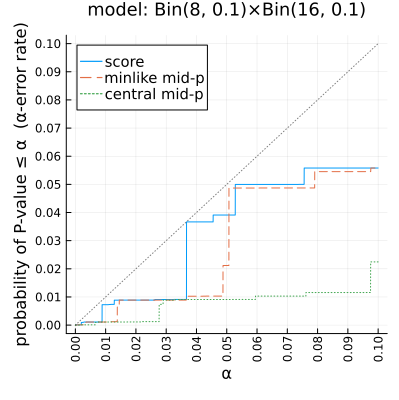

true expectation value: 
 1.6   6.4
 3.2  12.8

probability of P-value ≤ 5%  (α-error rate)
  score:          4.9%
  minlike mid-p:  4.8%
  central mid-p:  1.9%



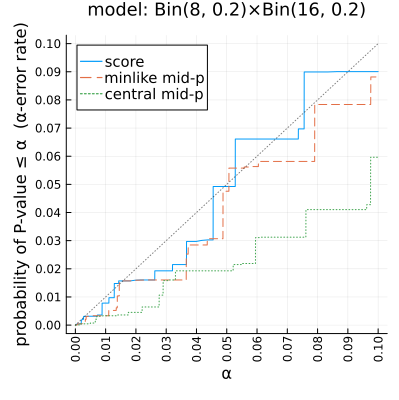

true expectation value: 
 2.4   5.6
 4.8  11.2

probability of P-value ≤ 5%  (α-error rate)
  score:          6.0%
  minlike mid-p:  4.8%
  central mid-p:  2.6%



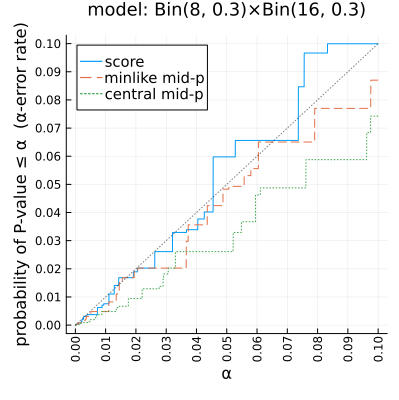

true expectation value: 
 3.2  4.8
 6.4  9.6

probability of P-value ≤ 5%  (α-error rate)
  score:          6.1%
  minlike mid-p:  3.9%
  central mid-p:  2.9%



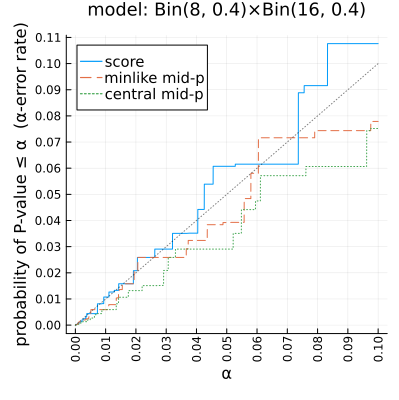

true expectation value: 
 4.0  4.0
 8.0  8.0

probability of P-value ≤ 5%  (α-error rate)
  score:          6.1%
  minlike mid-p:  3.4%
  central mid-p:  3.0%



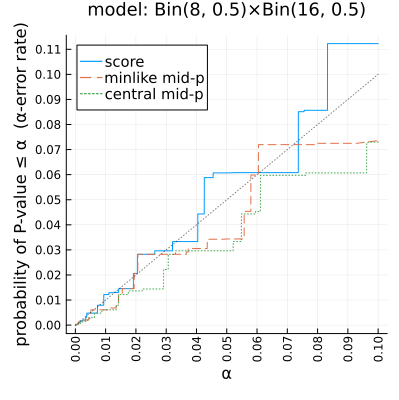

In [9]:
m, n = 8, 16
for q in 0.1:0.1:0.5
    plot_pvals(; bin1=Binomial(m, q), bin2=Binomial(n, q), niters=10^6, yates=0.1) |> display
end

true expectation value: 
 0.6  11.4
 1.0  19.0

probability of P-value ≤ 5%  (α-error rate)
  score:          0.8%
  minlike mid-p:  0.8%
  central mid-p:  0.7%



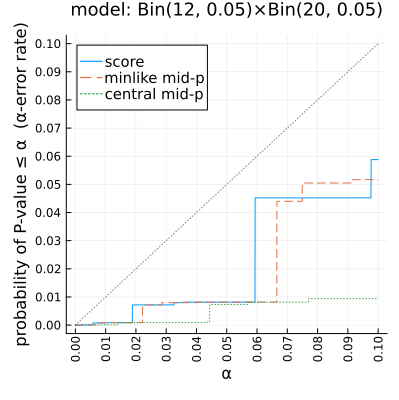

true expectation value: 
 1.2  10.8
 2.0  18.0

probability of P-value ≤ 5%  (α-error rate)
  score:          2.5%
  minlike mid-p:  2.4%
  central mid-p:  1.8%



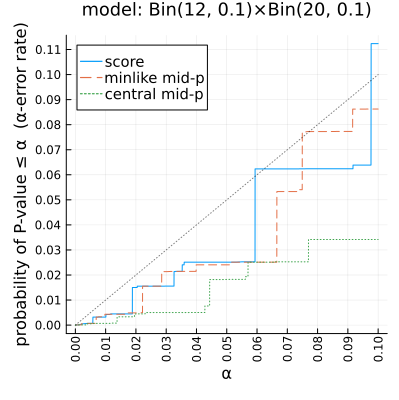

true expectation value: 
 1.8  10.2
 3.0  17.0

probability of P-value ≤ 5%  (α-error rate)
  score:          3.9%
  minlike mid-p:  3.5%
  central mid-p:  2.6%



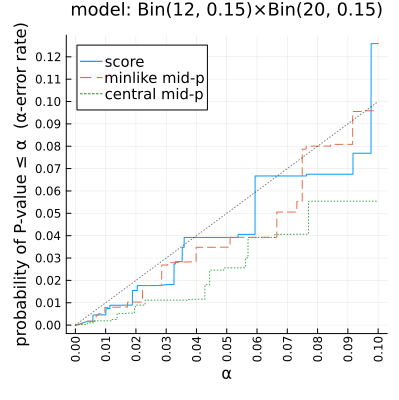

true expectation value: 
 2.4   9.6
 4.0  16.0

probability of P-value ≤ 5%  (α-error rate)
  score:          4.8%
  minlike mid-p:  4.1%
  central mid-p:  3.3%



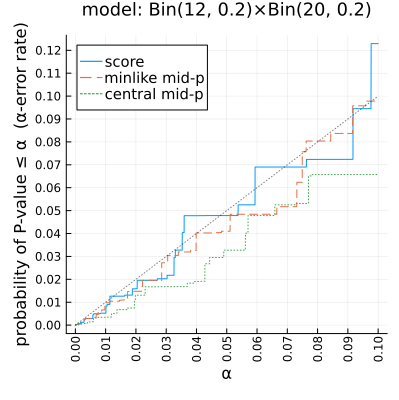

true expectation value: 
 3.0   9.0
 5.0  15.0

probability of P-value ≤ 5%  (α-error rate)
  score:          4.9%
  minlike mid-p:  4.5%
  central mid-p:  3.8%



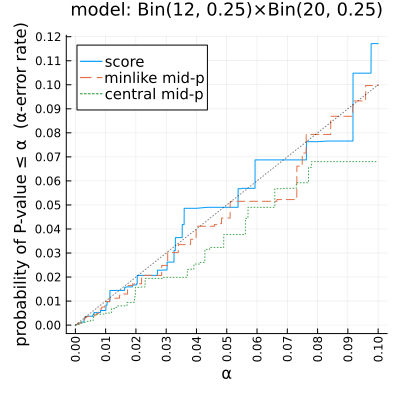

true expectation value: 
 3.6   8.4
 6.0  14.0

probability of P-value ≤ 5%  (α-error rate)
  score:          4.9%
  minlike mid-p:  4.9%
  central mid-p:  4.1%



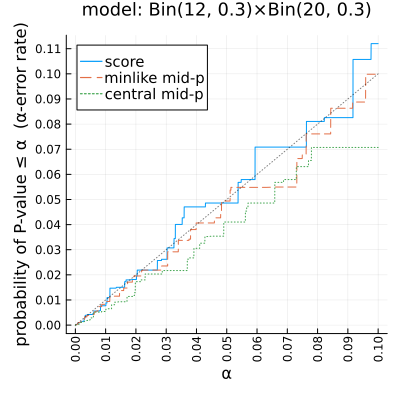

true expectation value: 
 4.2   7.8
 7.0  13.0

probability of P-value ≤ 5%  (α-error rate)
  score:          4.8%
  minlike mid-p:  5.3%
  central mid-p:  4.2%



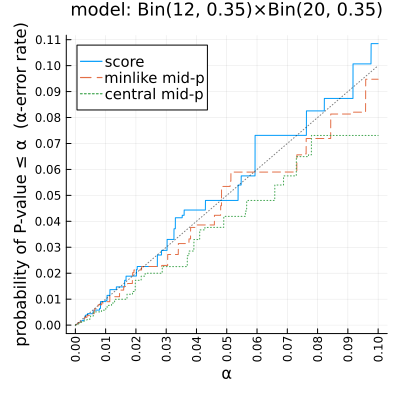

true expectation value: 
 4.8   7.2
 8.0  12.0

probability of P-value ≤ 5%  (α-error rate)
  score:          4.8%
  minlike mid-p:  5.5%
  central mid-p:  4.1%



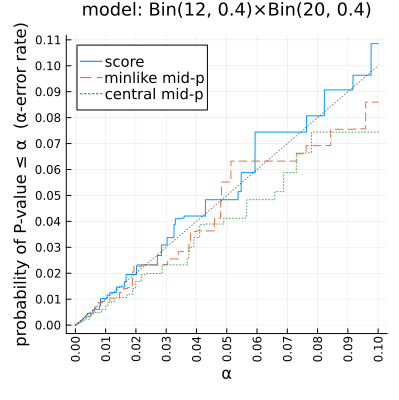

true expectation value: 
 5.4   6.6
 9.0  11.0

probability of P-value ≤ 5%  (α-error rate)
  score:          4.9%
  minlike mid-p:  5.5%
  central mid-p:  4.0%



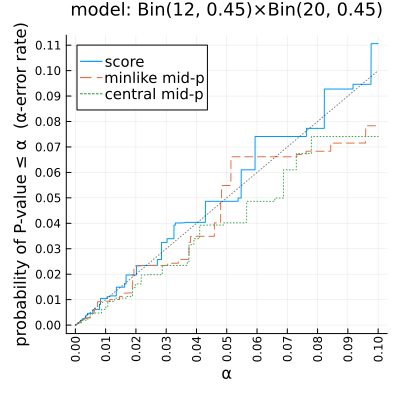

true expectation value: 
  6.0   6.0
 10.0  10.0

probability of P-value ≤ 5%  (α-error rate)
  score:          4.9%
  minlike mid-p:  5.5%
  central mid-p:  4.0%



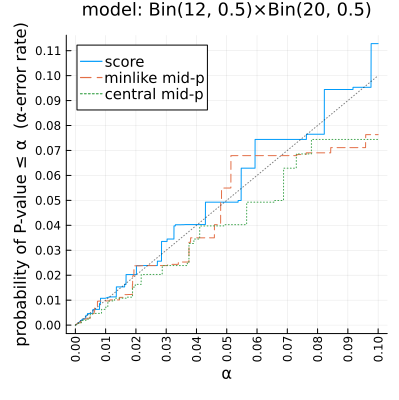

In [10]:
m, n = 12, 20
for q in 0.05:0.05:0.5
    plot_pvals(; bin1=Binomial(m, q), bin2=Binomial(n, q), niters=10^6) |> display
end

true expectation value: 
 4.8   7.2
 8.0  12.0

probability of P-value ≤ 5%  (α-error rate)
  score:          4.9%
  minlike mid-p:  5.6%
  central mid-p:  4.1%



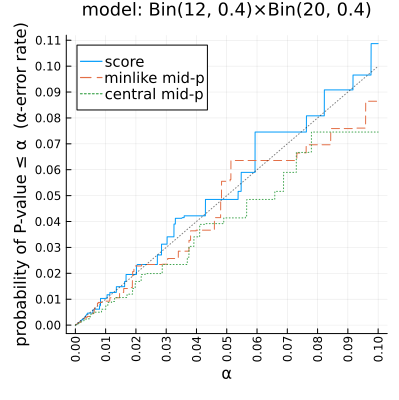

In [11]:
m, n = 12, 20
p, q = 0.4, 0.4
plot_pvals(; bin1=Binomial(m, p), bin2=Binomial(n, q), niters=10^6)

true expectation value: 
  2.4  9.6
 12.0  8.0

probability of P-value ≤ 5%  (power)
  score:          61.2%
  minlike mid-p:  64.5%
  central mid-p:  59.6%



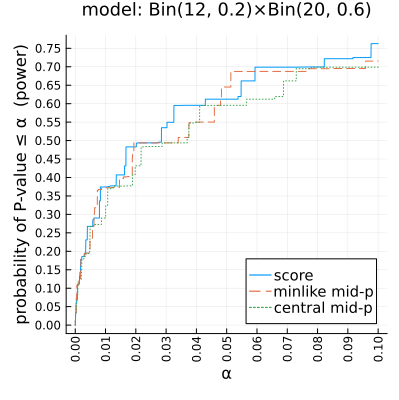

In [12]:
m, n = 12, 20
p, q = 0.2, 0.6
plot_pvals(; bin1=Binomial(m, p), bin2=Binomial(n, q), niters=10^6)

true expectation value: 
 4.8   7.2
 8.0  12.0

probability of P-value ≤ 5%  (α-error rate)
  score:          4.9%
  minlike mid-p:  5.6%
  central mid-p:  4.1%



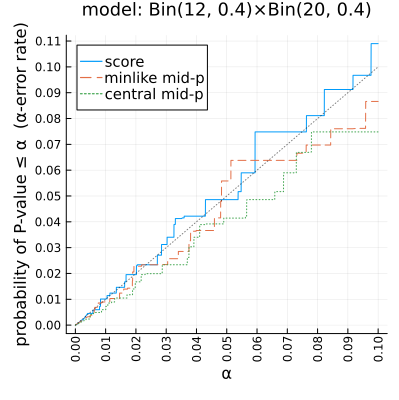

In [13]:
m, n = 12, 20
p, q = 0.4, 0.4
plot_pvals(; bin1=Binomial(m, p), bin2=Binomial(n, q), niters=10^6)

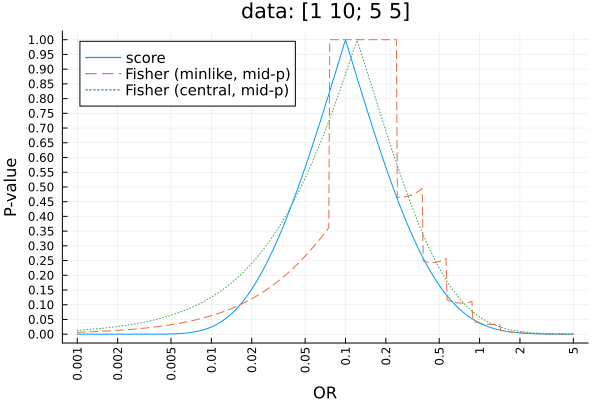

In [14]:
a, b, c, d = 1, 10, 5, 5

ωmin, ωmax = 0.001, 5
ωs = exp.(range(log(ωmin), log(ωmax), 500))
plot(ωs, ω -> pvalue_or_score(a, b, c, d; ω); label="score")
#plot!(ωs, ω -> pvalue_or_score(a, b, c, d; ω, h=1); label="score adjusted", ls=:dashdotdot)
#plot!(ωs, ω -> pvalue_or_fisher_minlike(a, b, c, d; ω, correction=0.0); label="Fisher (minlik)")
plot!(ωs, ω -> pvalue_or_fisher_minlike(a, b, c, d; ω, correction=0.5); label="Fisher (minlike, mid-p)", ls=:dash)
#plot!(ωs, ω -> pvalue_or_fisher_central(a, b, c, d; ω, correction=0.0); label="Fisher (central)")
plot!(ωs, ω -> pvalue_or_fisher_central(a, b, c, d; ω, correction=0.5); label="Fisher (central, mid-p)", ls=:dot)
xtick = Any[0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
xtick = xtick[ωmin .≤ xtick .≤ ωmax]
xtick = (xtick, string.(xtick))
plot!(; xscale=:log, xtick, ytick=0:0.05:1, xrotation=90)
plot!(xguide="OR", yguide="P-value")
plot!(legend=:topleft)
title!("data: $([a b; c d])")

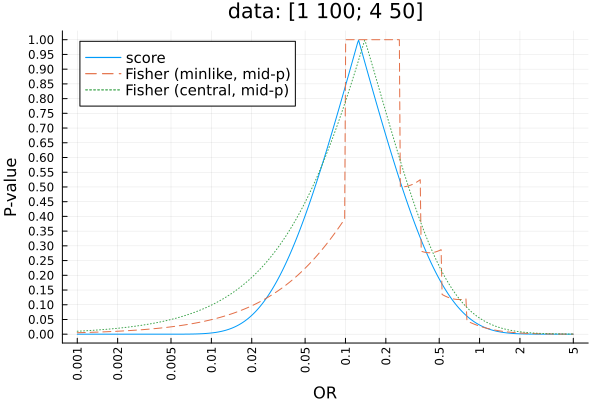

In [15]:
a, b, c, d = 1, 100, 4, 50

ωmin, ωmax = 0.001, 5
ωs = exp.(range(log(ωmin), log(ωmax), 500))
plot(ωs, ω -> pvalue_or_score(a, b, c, d; ω); label="score")
#plot!(ωs, ω -> pvalue_or_score(a, b, c, d; ω, h=1); label="score adjusted", ls=:dashdotdot)
#plot!(ωs, ω -> pvalue_or_fisher_minlike(a, b, c, d; ω, correction=0.0); label="Fisher (minlik)")
plot!(ωs, ω -> pvalue_or_fisher_minlike(a, b, c, d; ω, correction=0.5); label="Fisher (minlike, mid-p)", ls=:dash)
#plot!(ωs, ω -> pvalue_or_fisher_central(a, b, c, d; ω, correction=0.0); label="Fisher (central)")
plot!(ωs, ω -> pvalue_or_fisher_central(a, b, c, d; ω, correction=0.5); label="Fisher (central, mid-p)", ls=:dot)
xtick = Any[0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
xtick = xtick[ωmin .≤ xtick .≤ ωmax]
xtick = (xtick, string.(xtick))
plot!(; xscale=:log, xtick, ytick=0:0.05:1, xrotation=90)
plot!(xguide="OR", yguide="P-value")
plot!(legend=:topleft)
title!("data: $([a b; c d])")

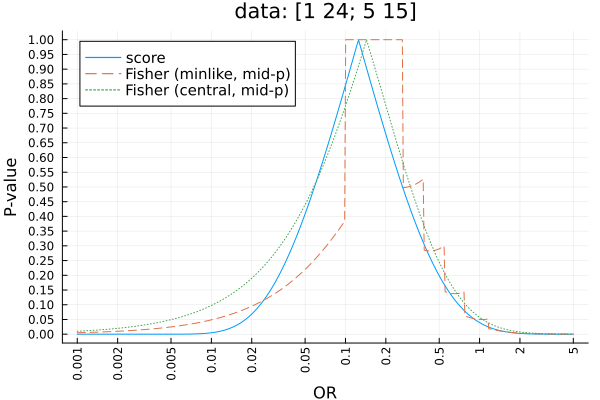

In [16]:
a, b, c, d = 1, 24, 5, 15

ωmin, ωmax = 0.001, 5
ωs = exp.(range(log(ωmin), log(ωmax), 500))
plot(ωs, ω -> pvalue_or_score(a, b, c, d; ω); label="score")
#plot!(ωs, ω -> pvalue_or_score(a, b, c, d; ω, h=1); label="score adjusted", ls=:dashdot)
#plot!(ωs, ω -> pvalue_or_fisher_minlike(a, b, c, d; ω, correction=0.0); label="Fisher (minlik)")
plot!(ωs, ω -> pvalue_or_fisher_minlike(a, b, c, d; ω, correction=0.5); label="Fisher (minlike, mid-p)", ls=:dash)
#plot!(ωs, ω -> pvalue_or_fisher_central(a, b, c, d; ω, correction=0.0); label="Fisher (central)")
plot!(ωs, ω -> pvalue_or_fisher_central(a, b, c, d; ω, correction=0.5); label="Fisher (central, mid-p)", ls=:dot)
xtick = Any[0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
xtick = xtick[ωmin .≤ xtick .≤ ωmax]
xtick = (xtick, string.(xtick))
plot!(; xscale=:log, xtick, ytick=0:0.05:1, xrotation=90)
plot!(xguide="OR", yguide="P-value")
plot!(legend=:topleft)
title!("data: $([a b; c d])")

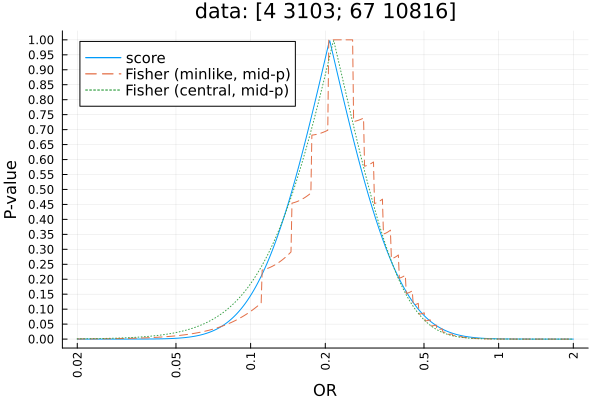

In [17]:
a, b, c, d = 4, 3107-4, 67, 10883-67

ωmin, ωmax = 0.02, 2
ωs = exp.(range(log(ωmin), log(ωmax), 500))
plot(ωs, ω -> pvalue_or_score(a, b, c, d; ω); label="score")
#plot!(ωs, ω -> pvalue_or_score(a, b, c, d; ω, h=1); label="score adjusted", ls=:dashdotdot)
#plot!(ωs, ω -> pvalue_or_fisher_minlike(a, b, c, d; ω, correction=0.0); label="Fisher (minlik)")
plot!(ωs, ω -> pvalue_or_fisher_minlike(a, b, c, d; ω, correction=0.5); label="Fisher (minlike, mid-p)", ls=:dash)
#plot!(ωs, ω -> pvalue_or_fisher_central(a, b, c, d; ω, correction=0.0); label="Fisher (central)")
plot!(ωs, ω -> pvalue_or_fisher_central(a, b, c, d; ω, correction=0.5); label="Fisher (central, mid-p)", ls=:dot)
xtick = Any[0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
xtick = xtick[ωmin .≤ xtick .≤ ωmax]
xtick = (xtick, string.(xtick))
plot!(; xscale=:log, xtick, ytick=0:0.05:1, xrotation=90)
plot!(xguide="OR", yguide="P-value")
plot!(legend=:topleft)
title!("data: $([a b; c d])")

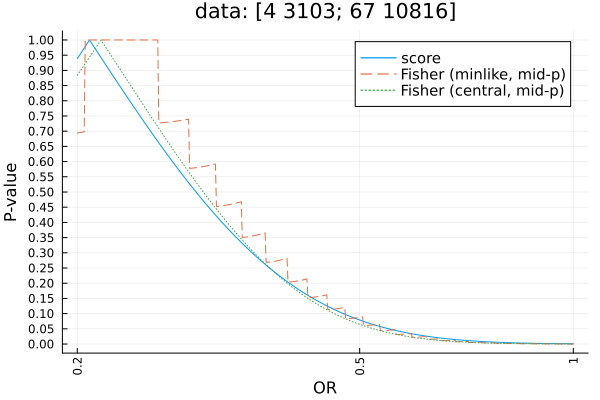

In [18]:
a, b, c, d = 4, 3107-4, 67, 10883-67

ωmin, ωmax = 0.2, 1
ωs = exp.(range(log(ωmin), log(ωmax), 500))
plot(ωs, ω -> pvalue_or_score(a, b, c, d; ω); label="score")
#plot!(ωs, ω -> pvalue_or_score(a, b, c, d; ω, h=1); label="score adjusted", ls=:dashdotdot)
#plot!(ωs, ω -> pvalue_or_fisher_minlike(a, b, c, d; ω, correction=0.0); label="Fisher (minlik)")
plot!(ωs, ω -> pvalue_or_fisher_minlike(a, b, c, d; ω, correction=0.5); label="Fisher (minlike, mid-p)", ls=:dash)
#plot!(ωs, ω -> pvalue_or_fisher_central(a, b, c, d; ω, correction=0.0); label="Fisher (central)")
plot!(ωs, ω -> pvalue_or_fisher_central(a, b, c, d; ω, correction=0.5); label="Fisher (central, mid-p)", ls=:dot)
xtick = Any[0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
xtick = xtick[ωmin .≤ xtick .≤ ωmax]
xtick = (xtick, string.(xtick))
plot!(; xscale=:log, xtick, ytick=0:0.05:1, xrotation=90)
plot!(xguide="OR", yguide="P-value")
plot!(legend=:topright)
title!("data: $([a b; c d])")